In [1]:
import numpy as np
import pandas as pd
import mne
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

ЗАГРУЗКА И ПРЕПРОЦЕССИНГ

In [2]:
raw = mne.io.read_raw_nihon('./00000000/NKT/EEG2100/FA0183FS.EEG', preload=True)
sfreq = raw.info['sfreq']  # 500 Гц

# Создание биполярного монтажа (как в DotNetChecker)
anodes = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4',
          'Fp1', 'Fp2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6',
          'Fz', 'Cz']
cathodes = ['F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
            'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2',
            'Cz', 'Pz']
ch_names = [f'{a}-{c}' for a, c in zip(anodes, cathodes)]

raw_bip = mne.set_bipolar_reference(
    raw, anode=anodes, cathode=cathodes, 
    ch_name=ch_names, drop_refs=True, copy=True
)
raw_bip.pick(ch_names)  # Только нужные 18 каналов

# Получаем данные
data = raw_bip.get_data()  # [18, n_times]
print(f"Данные загружены: {data.shape}")
print(f"Частота дискретизации: {sfreq} Гц")

Loading FA0183FS.EEG
Found 21E file, reading channel names.
Reading header from /home/jovyan/vspyatochkin/diploma/00000000/NKT/EEG2100/FA0183FS.EEG
Reading 0 ... 19248999  =      0.000 ... 38497.998 secs...


/tmp/ipykernel_605090/2305222571.py:1: RuntimeWarning: No PNT file exists. Metadata will be blank
  raw = mne.io.read_raw_nihon('./00000000/NKT/EEG2100/FA0183FS.EEG', preload=True)


Found LOG file, reading events.
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=18, n_times=19249000
    Range : 0 ... 19248999 =      0.000 ... 38497.998 secs
Ready.
Added the following bipolar channels:
Fp1-F3, Fp2-F4, F3-C3, F4-C4, C3-P3, C4-P4, P3-O1, P4-O2, Fp1-F7, Fp2-F8, F7-T3, F8-T4, T3-T5, T4-T6, T5-O1, T6-O2, Fz-Cz, Cz-Pz
Данные загружены: (18, 19249000)
Частота дискретизации: 500.0 Гц


СОЗДАНИЕ МЕТОК ДЛЯ КЛАССИФИКАЦИИ

In [3]:
df = pd.read_csv('depd_intervals.csv')  # channel, start_seconds, end_seconds

# Размечены только первые 36 минут
ANNOTATED_DURATION = 36 * 60
annotated_samples = int(ANNOTATED_DURATION * sfreq)
data = data[:, :annotated_samples]  # [18, 1,080,000]
n_channels, n_times = data.shape

print(f"Данные для классификации: {data.shape}")
print(f"Длительность: {n_times/sfreq/60:.1f} минут")
print(f"Всего событий ДЭРД: {len(df)}")

# Создаем список событий для быстрого поиска
events = []
for _, row in df.iterrows():
    ch = int(row['channel']) - 1  # Каналы с 1 → с 0
    start_sample = int(row['start_seconds'] * sfreq)
    end_sample = int(row['end_seconds'] * sfreq)
    
    if 0 <= ch < n_channels and start_sample < n_times:
        end_sample = min(end_sample, n_times)
        events.append({
            'channel': ch,
            'start': start_sample,
            'end': end_sample,
            'duration': end_sample - start_sample
        })

print(f"Загружено {len(events)} событий")
if events:
    avg_duration = np.mean([e['duration'] for e in events]) / sfreq
    print(f"Средняя длительность ДЭРД: {avg_duration:.3f} сек")

Данные для классификации: (18, 1080000)
Длительность: 36.0 минут
Всего событий ДЭРД: 387
Загружено 387 событий
Средняя длительность ДЭРД: 0.326 сек


СОЗДАНИЕ ОКОН

In [4]:
def create_windows_for_classification(data, events, window_sec=2.0, overlap_sec=1.5):
    """Создает короткие окна для классификации"""
    window_samples = int(window_sec * sfreq)  # 1000 отсчетов (2 сек)
    step_samples = int((window_sec - overlap_sec) * sfreq)  # 250 отсчетов (0.5 сек)
    
    windows_data = []
    windows_labels = []  # Метки: [0/1 для каждого канала]
    
    n_samples = data.shape[1]
    
    # Создаем хэш-таблицу событий для быстрого поиска
    # Ключ: (start_sample, channel), Значение: end_sample
    event_dict = {}
    for event in events:
        key = (event['start'], event['channel'])
        event_dict[key] = event['end']
    
    for start in range(0, n_samples - window_samples + 1, step_samples):
        end = start + window_samples
        
        window_data = data[:, start:end]  # [18, 1000]
        
        # Метка: есть ли ДЭРД в этом окне для каждого канала
        label = np.zeros(n_channels, dtype=float)
        
        # Проверяем для каждого канала
        for ch in range(n_channels):
            # Ищем события на этом канале, которые пересекаются с окном
            has_depd = False
            for event_start, event_ch in event_dict.keys():
                if event_ch == ch:  # Событие на этом канале
                    event_end = event_dict[(event_start, ch)]
                    # Проверяем пересечение события с окном
                    if not (event_end <= start or event_start >= end):
                        has_depd = True
                        break
            
            label[ch] = 1.0 if has_depd else 0.0
        
        windows_data.append(window_data)
        windows_labels.append(label)
    
    return np.array(windows_data), np.array(windows_labels)

# Создаем окна 2 секунды
windows_data, windows_labels = create_windows_for_classification(
    data, events, window_sec=2.0, overlap_sec=1.5
)

print(f"\nСоздано окон: {len(windows_data)}")
print(f"Размер окна: {windows_data[0].shape}")
print(f"Процент окон с ДЭРД: {100 * windows_labels.sum() / windows_labels.size:.2f}%")
print(f"Окон с ДЭРД: {(windows_labels.sum(axis=1) > 0).sum()} из {len(windows_data)}")



Создано окон: 4317
Размер окна: (18, 1000)
Процент окон с ДЭРД: 1.99%
Окон с ДЭРД: 732 из 4317


БАЛАНСИРОВКА

In [8]:
positive_indices = np.where(windows_labels.sum(axis=1) > 0)[0]
negative_indices = np.where(windows_labels.sum(axis=1) == 0)[0]

print(f"Окон с ДЭРД: {len(positive_indices)}")
print(f"Окон без ДЭРД: {len(negative_indices)}")

# Берем все положительные и столько же отрицательных
selected_negatives = np.random.choice(
    negative_indices, 
    size=min(len(positive_indices), len(negative_indices)), 
    replace=False
)

balanced_indices = np.concatenate([positive_indices, selected_negatives])
np.random.shuffle(balanced_indices)

balanced_data = windows_data[balanced_indices]
balanced_labels = windows_labels[balanced_indices]

print(f"После балансировки:")
print(f"Всего окон: {len(balanced_data)}")
print(f"Окон с ДЭРД: {len(positive_indices)} ({len(positive_indices)/len(balanced_data):.1%})")

Окон с ДЭРД: 732
Окон без ДЭРД: 3585
После балансировки:
Всего окон: 1464
Окон с ДЭРД: 732 (50.0%)


РАЗДЕЛЕНИЕ НА TRAIN/VAL

In [ ]:
TRAIN_RATIO = 0.8
split_idx = int(len(balanced_data) * TRAIN_RATIO)

split_idx = int(len(balanced_data) * 0.8)
train_data = balanced_data[:split_idx]
train_labels = balanced_labels[:split_idx]
val_data = balanced_data[split_idx:]
val_labels = balanced_labels[split_idx:]

print(f"Окна для тренировки: {len(train_data)}")
print(f"Окна для валидации: {len(val_data)}")


Train: 1171 окон
Val: 293 окон


АРХИТЕКТУРА МОДЕЛИ

In [9]:
class DEPDClassifier(nn.Module):
    """Классификатор: есть ли ДЭРД в окне для каждого канала"""
    def __init__(self, n_channels=18, window_size=15000):
        super().__init__()
        
        # 1. Признаки из каждого канала
        self.channel_features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=101, padding=50),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(4),
            
            nn.Conv1d(16, 32, kernel_size=51, padding=25),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            
            nn.Conv1d(32, 64, kernel_size=25, padding=12),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # [B, 64, 1]
        )
        
        # 2. Объединение признаков со всех каналов
        self.fc = nn.Sequential(
            nn.Linear(64 * n_channels, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, n_channels)  # По одному выходу на канал
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x: [B, 18, 15000]
        batch_size, n_channels, window_size = x.shape
        
        # Обрабатываем каждый канал отдельно
        channel_features = []
        for ch in range(n_channels):
            # Берем один канал: [B, 1, 15000]
            channel_data = x[:, ch:ch+1, :]
            features = self.channel_features(channel_data)  # [B, 64, 1]
            features = features.view(batch_size, -1)  # [B, 64]
            channel_features.append(features)
        
        # Объединяем: [B, 64*18]
        combined = torch.cat(channel_features, dim=1)
        
        # Классификация
        out = self.fc(combined)  # [B, 18]
        return self.sigmoid(out)

ДАТАЛОАДЕРЫ

In [10]:
class EEGClassificationDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)   # [B, 18, 1000]
        self.labels = torch.FloatTensor(labels)  # [B, 18]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = EEGClassificationDataset(train_data, train_labels)
val_dataset = EEGClassificationDataset(val_data, val_labels)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Батчей в train: {len(train_loader)}")
print(f"Батчей в val: {len(val_loader)}")

Batch size: 32
Батчей в train: 37
Батчей в val: 10


ТРЕНИРОВКА

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Устройство: {device}")

model = DEPDClassifier(n_channels=18).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.BCELoss()  # Самый простой для начала
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Функции для тренировки и валидации
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch_data, batch_mask in loader:
        batch_data = batch_data.to(device)
        batch_mask = batch_mask.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_mask)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_data, batch_labels in loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            outputs = model(batch_data)
            val_loss += criterion(outputs, batch_labels).item()
            
            pred = (outputs > 0.5).float()
            all_preds.append(pred.cpu())
            all_targets.append(batch_labels.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    # Вычисляем F1-score
    tp = (all_preds * all_targets).sum().item()
    fp = (all_preds * (1 - all_targets)).sum().item()
    fn = ((1 - all_preds) * all_targets).sum().item()
    
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6) if (precision + recall) > 0 else 0
    
    return val_loss / len(loader), f1, precision, recall


# Тренировочный цикл с сохранением истории
history = {
    'train_loss': [],
    'val_loss': [],
    'f1': [],
    'precision': [],
    'recall': [],
    'epochs': []
}

best_f1 = 0
patience = 10
patience_counter = 0

for epoch in range(100):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    if epoch % 2 == 0:
        val_loss, f1, precision, recall = validate(model, val_loader, criterion, device)
        
        # Сохраняем историю
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['f1'].append(f1)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['epochs'].append(epoch)
        
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | F1: {f1:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f}")
    
        # Ранняя остановка
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Ранняя остановка на эпохе {epoch}")
            break
    else:
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f}")

Устройство: cuda
Epoch   0 | Train Loss: 0.3244 | Val Loss: 0.2133 | F1: 0.0000 | Prec: 0.0000 | Rec: 0.0000
Epoch   1 | Train Loss: 0.1728
Epoch   2 | Train Loss: 0.1549 | Val Loss: 0.3126 | F1: 0.0000 | Prec: 0.0000 | Rec: 0.0000
Epoch   3 | Train Loss: 0.1452
Epoch   4 | Train Loss: 0.1396 | Val Loss: 0.4549 | F1: 0.0133 | Prec: 1.0000 | Rec: 0.0067
Epoch   5 | Train Loss: 0.1338
Epoch   6 | Train Loss: 0.1268 | Val Loss: 0.2478 | F1: 0.1223 | Prec: 0.7143 | Rec: 0.0669
Epoch   7 | Train Loss: 0.1159
Epoch   8 | Train Loss: 0.1152 | Val Loss: 0.1709 | F1: 0.0133 | Prec: 1.0000 | Rec: 0.0067
Epoch   9 | Train Loss: 0.1136
Epoch  10 | Train Loss: 0.1084 | Val Loss: 0.3839 | F1: 0.0132 | Prec: 0.6667 | Rec: 0.0067
Epoch  11 | Train Loss: 0.1076
Epoch  12 | Train Loss: 0.1027 | Val Loss: 0.2488 | F1: 0.2152 | Prec: 0.4000 | Rec: 0.1472
Epoch  13 | Train Loss: 0.0974
Epoch  14 | Train Loss: 0.0953 | Val Loss: 0.2168 | F1: 0.0128 | Prec: 0.1538 | Rec: 0.0067
Epoch  15 | Train Loss: 0.0947

ГРАФИКИ ОБУЧЕНИЯ

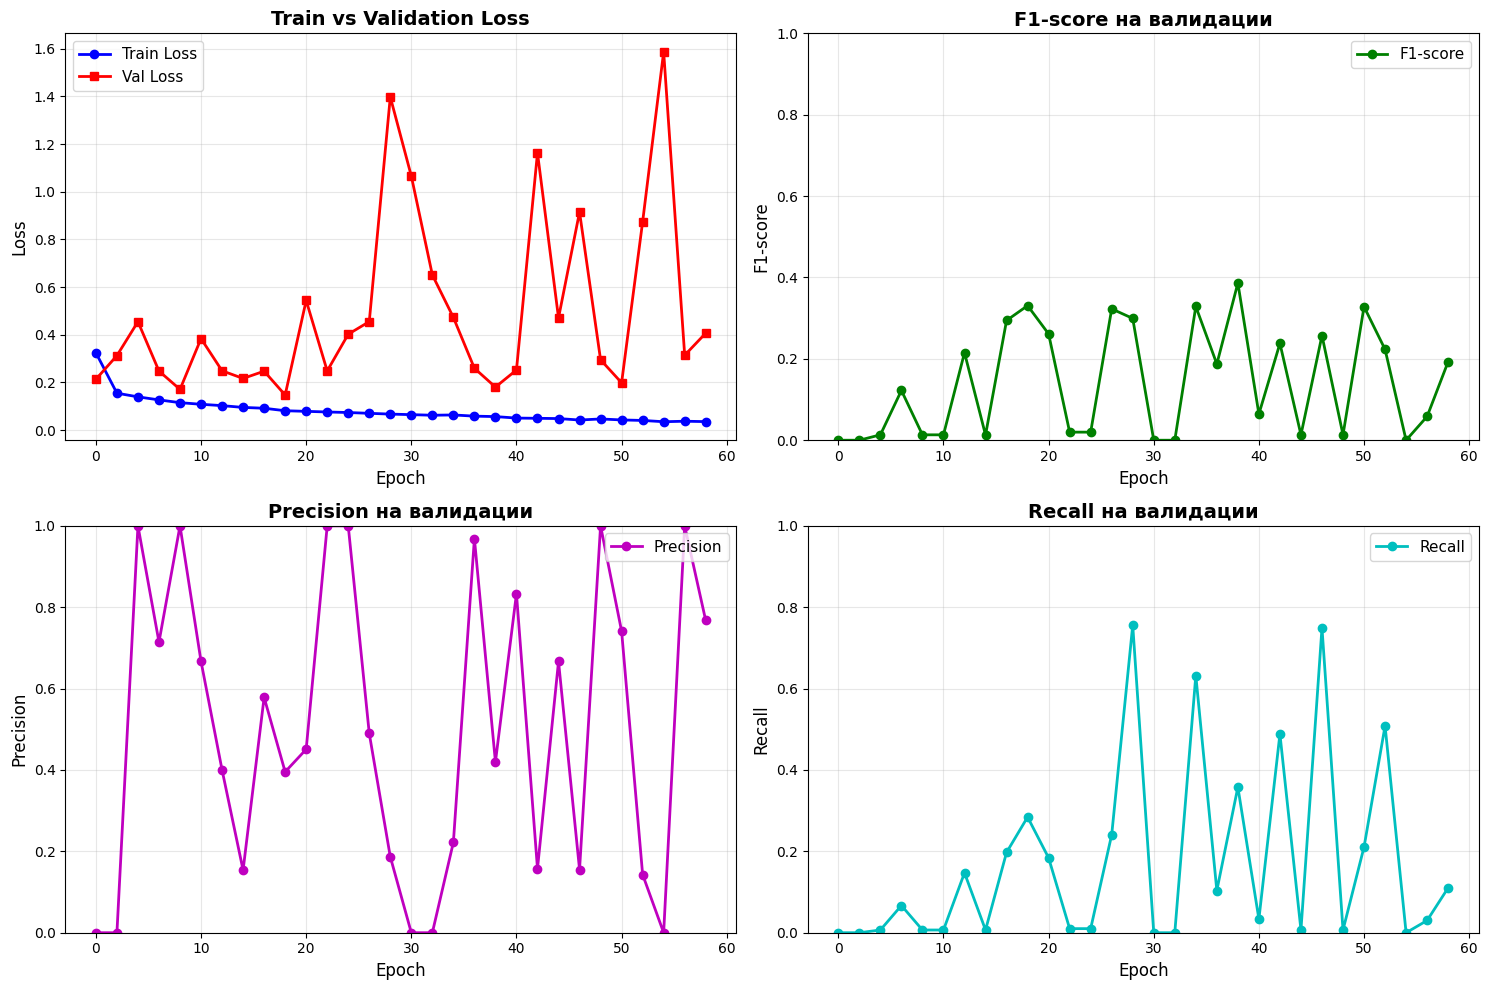


Лучшие результаты:
Лучший F1-score: 0.3863 на эпохе 38
Минимальный Val Loss: 0.1472 на эпохе 18
Финальные метрики:
  F1-score: 0.1930
  Precision: 0.7674
  Recall: 0.1104


In [20]:
import matplotlib.pyplot as plt

# Создаем фигуру с графиками
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# График 1: Train и Val Loss
axes[0, 0].plot(history['epochs'], history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
axes[0, 0].plot(history['epochs'], history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# График 2: F1-score
axes[0, 1].plot(history['epochs'], history['f1'], 'g-o', label='F1-score', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('F1-score', fontsize=12)
axes[0, 1].set_title('F1-score на валидации', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# График 3: Precision
axes[1, 0].plot(history['epochs'], history['precision'], 'm-o', label='Precision', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Precision на валидации', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# График 4: Recall
axes[1, 1].plot(history['epochs'], history['recall'], 'c-o', label='Recall', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].set_title('Recall на валидации', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# лучшие результаты
print(f"\nЛучшие результаты:")
print(f"Лучший F1-score: {max(history['f1']):.4f} на эпохе {history['epochs'][np.argmax(history['f1'])]}")
print(f"Минимальный Val Loss: {min(history['val_loss']):.4f} на эпохе {history['epochs'][np.argmin(history['val_loss'])]}")
print(f"Финальные метрики:")
print(f"  F1-score: {history['f1'][-1]:.4f}")
print(f"  Precision: {history['precision'][-1]:.4f}")
print(f"  Recall: {history['recall'][-1]:.4f}")

ТЕСТИРОВАНИЕ

In [17]:
if os.path.exists('best_model.pth'):
    model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Предсказание на нескольких примерах
with torch.no_grad():
    # Берем несколько примеров из валидации
    n_test = 294
    test_samples = val_data[:n_test]  # [5, 18, 1000]
    test_labels = val_labels[:n_test]  # [5, 18]
    
    test_tensor = torch.FloatTensor(test_samples).to(device)
    predictions = model(test_tensor)
    
    predictions_np = predictions.cpu().numpy()  # [5, 18]
    true_labels_np = test_labels  # [5, 18]
    
    # Вычисляем метрики
    pred_binary = (predictions_np > 0.5).astype(float)
    
    # Accuracy по каналам
    correct = (pred_binary == true_labels_np).mean()
    
    # F1-score для положительного класса
    tp = (pred_binary * true_labels_np).sum()
    fp = (pred_binary * (1 - true_labels_np)).sum()
    fn = ((1 - pred_binary) * true_labels_np).sum()
    
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6) if (precision + recall) > 0 else 0
    
    print(f"\nТест на {n_test} примерах:")
    print(f"Accuracy: {correct:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Детальная информация по первому примеру
    print(f"\nПервый пример:")
    print(f"Истинные метки: {true_labels_np[0].astype(int)}")
    print(f"Предсказания:   {pred_binary[0].astype(int)}")
    print(f"Вероятности:    {predictions_np[0].round(3)}")
    
    # Проверяем, на каких каналах были ДЭРД
    depd_channels = np.where(true_labels_np[0] > 0.5)[0]
    if len(depd_channels) > 0:
        print(f"Каналы с ДЭРД: {[ch+1 for ch in depd_channels]}")
    else:
        print("В этом окне нет ДЭРД")


Тест на 294 примерах:
Accuracy: 0.8677
Precision: 0.2704
Recall: 0.7860
F1-score: 0.4024

Первый пример:
Истинные метки: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Предсказания:   [1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Вероятности:    [0.939 0.    0.999 0.    0.    0.    0.    0.    1.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
В этом окне нет ДЭРД
